In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Joachim DAVID, December 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
# @book{ebeling2004introduction,
#   title={An introduction to reliability and maintainability engineering},
#   author={Ebeling, C.E.},
#   isbn={9780070421387},
#   series={Electrical engineering series},
#   url={https://books.google.be/books?id=iFumyeVLIEAC},
#   year={2004},
#   publisher={McGraw-Hill}
# }

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
from visualize_lib import plot_gantt, show_energy_plot
from datetime import datetime, timedelta

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

#print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
choices = {'prod': ('productionfile.csv', 'prod_speed.csv'),
           'pack': ('packagingfile_old.csv', 'pack_speed.csv')}
file_used, file_speed = choices['prod']

round_to = 600 # seconds
break_pauses = 7200 # seconds # breaks will be split in these periods
turn_off_if = 3600 # seconds # the machine can be turned off if time if larger than this!!!! 
# turn_off_if has to be smaller than break_pauses in order for this program to run well
assert (turn_off_if < break_pauses)

In [3]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [4]:
# VARIABLES
# cutoff_perc = 100
# dtcutoff_perc = 100
reasons_relative = [1, 3, 5, 7, 8]
reasons_absolute = [9, 10, 11]
reasons_break = []
reasons_not_considered = [0, 2]
considered_reasons = reasons_relative + reasons_absolute + reasons_break
# group = True
choice='PastaType'

# PLOT_RANGE:
plotrange = datetime(2016, 11, 3, 6, 0), datetime(2016, 12, 3, 0, 0)

assert (set(considered_reasons + reasons_not_considered) == set(all_reasons))

In [5]:
def add_column_type(df, from_col='ArticleName', choice='BigPack'):
    choices = ['BigPack', 'Marque', 'PastaType', 'BigPack-simple']
    newname = choice

    if newname == choices[0]:
        stringlist = [' 8', ' 10', ' 12', ' 16', ' 18' ,' 20']
    elif newname == choices[1]:
        stringlist = ['DLL 365', 'VALUE', 'AMBRA', 'EVERYDAY', 'WINNY', 'CARREFOUR', 'ALDI', 'ECO+', 'TOSCA', 'CASA ITALIANA',
                     'EUROSHOPPER', 'AH', 'PASTA MARE', 'OKE', 'TOP BUDGET', 'FIORINI', 'BIO VILLAGE', 'MONOPP', 'RINATURA',
                     'JUMBO', 'BONI', 'CASINO', 'TURINI']
    elif newname == choices[2]:
        stringlist = [['MACARONI', 'MAC.'], 'FUSILLI', ['SPIRELLI', 'SPIRAL', 'TORSADES'], ['HORENTJE', 'HELICES'], 
                      ['VERMICELLI', 'VERMICELL'], ['NOODLES', 'NOUILLES'], 'TORTI',
                     ['PENNE', 'PIPE'], ['ELLEBOOGJES', 'COQUILLETTE', 'COQ.'], 'ZITTI', 'MIE', 'NONE']
    elif newname == choices[3]:
        stringlist = [ ['SMALL', ' 8', ' 10', ' 12'], ['LARGE', ' 16', ' 18', ' 20']]
    else:
        raise NameError("The choice '{}' is not defined".format(newname))
    
    # Generate a new column with categories in the dataframe
    bp = np.full(df.shape[0], 'Other')
    name = df[from_col]
    for s in stringlist:
        if type(s) == list:
            new_s = ('|'.join(s))
            bp = np.where(name.str.contains(new_s), s[0], bp)
        else:
            if newname == 'BigPack':
                bp = np.where(name.str.contains(s), s + 'X', bp)
            else:
                bp = np.where(name.str.contains(s), s, bp)
    df[newname] = bp
    return df
df = add_column_type(df, choice=choice)

## Merge per production

### Merge per production, Absolute reasons

In [6]:
from probplot import merge_per_production
df_agg = merge_per_production(df, [choice, 'ProductionRequestId', 'Type', 'ReasonId'], reasons_relative, reasons_absolute)

In [7]:
print(df_agg.index.get_level_values(0).unique())
df_agg.tail()

Index(['ELLEBOOGJES', 'HORENTJE', 'MACARONI', 'MIE', 'Other', 'PENNE',
       'SPIRELLI', 'VERMICELLI', 'ZITTI'],
      dtype='object', name='PastaType')


DownTime1  DownTime3  DownTime5  DownTime7  \
PastaType ProductionRequestId                                               
ZITTI     75560.0                    0.0        0.0        0.0        0.0   
          75800.0                    0.0        0.0    18216.0        0.0   
          76046.0                    0.0        0.0     8123.0        0.0   
          76168.0                    0.0        0.0     1032.0        0.0   
          77204.0                    0.0        0.0    39637.0        0.0   

                               DownTime8  DownTime   RunTime  TotalDuration  \
PastaType ProductionRequestId                                                 
ZITTI     75560.0                    0.0       0.0   52313.0        52313.0   
          75800.0                 1734.0   19950.0  121826.0       141776.0   
          76046.0                    0.0    8123.0  209039.0       217162.0   
          76168.0                  338.0    1370.0   67397.0        68767.0   
          77204.0                    0.0   39637.0   76795.0       116432.0   

                               DownTimeRate  RunTimeRate  DownTime9  \
PastaType ProductionRequestId                                         
ZITTI     75560.0                  0.000000     1.000000        0.0   
          75800.0                  0.140715     0.859285        0.0   
          76046.0                  0.037405     0.962595        0.0   
          76168.0                  0.019922     0.980078        0.0   
          77204.0                  0.340430     0.659570        0.0   

                               DownTime10  DownTime11  Preparations  
PastaType ProductionRequestId                                        
ZITTI     75560.0                  1794.0     30533.0       32327.0  
          75800.0                  1096.0     60444.0       61540.0  
          76046.0                   700.0    321638.0      322338.0  
          76168.0                  1627.0         0.0        1627.0  
          77204.0                  1675.0         0.0        1675.0

C:\Users\jdavid\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


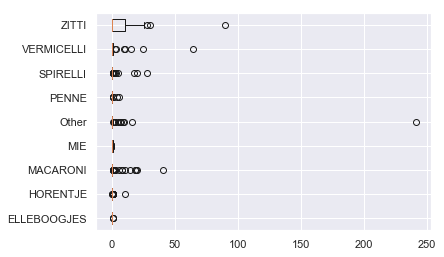

In [8]:
def get_downtimes_absolute(df_agg, column):    
    downtimes = []
    lab = df_agg.index.get_level_values(0).unique()
    for pastatype in lab:
        temp_df = df_agg.loc[pastatype]
        downtime9and10 = (temp_df[column])/3600
        downtimes.append(downtime9and10)
    return lab, downtimes
cat, downtimes = get_downtimes_absolute(df_agg, 'Preparations')
downtimes_dict = dict(zip(cat, downtimes))
plt.boxplot(downtimes, vert=False, labels=cat)
plt.show()

In [9]:
from scipy.stats.mstats import f_oneway
d_list = []
for downt in downtimes:
    d_list.append(np.array(downt))
f = f_oneway(*d_list)
print(f)
if f.pvalue >= 0.05:
    print('No statistical evidence of different distributions')
    stat=False
else:
    print('Statistical evidence of different distributions')
    stat=True

F_onewayResult(statistic=5.472069092304379, pvalue=8.445587078635856e-07)
Statistical evidence of different distributions


C:\Users\jdavid\Anaconda3\lib\site-packages\numpy\ma\core.py:6649: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text yticklabel objects>)

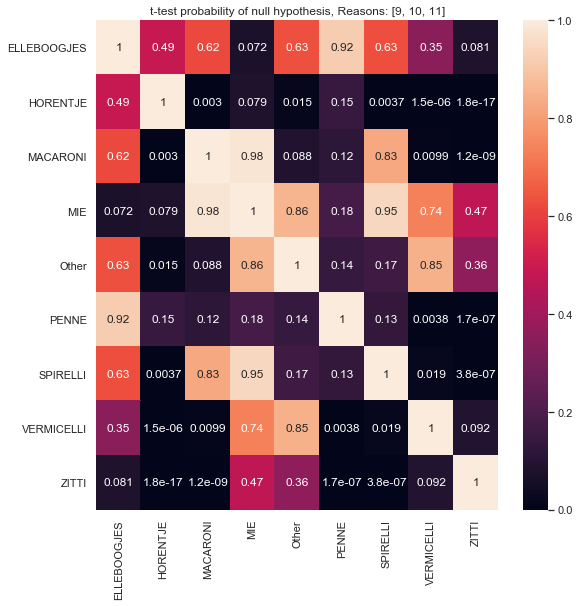

In [10]:
from scipy.stats import ttest_ind
from itertools import combinations, permutations
import seaborn as sns; sns.set()
row = list(df_agg.index.get_level_values(0).unique())
pvalues_df = pd.DataFrame(1, row, row)
for i, j in permutations(row, 2):
    tt = ttest_ind(downtimes_dict[i], downtimes_dict[j])
    pvalues_df.loc[i, j] = tt.pvalue
plt.figure(figsize=(len(row), len(row)))
sns.heatmap(pvalues_df, annot=True)
plt.title('t-test probability of null hypothesis, Reasons: {}'.format(reasons_absolute))
plt.yticks(rotation=0)
#plt.savefig('D:/temp/ttest.png', dpi=300, layout='tight')

In [11]:
row = list(df_agg.index.get_level_values(0).unique())
from scipy.stats.mstats import f_oneway
anova_list = []
for r in row:
    temp = df_agg.loc[r, 'RunTimeRate']
    anova_list.append(np.array(temp))
    #print(anova_list)
f = f_oneway(*anova_list)
print(f)
if f.pvalue >= 0.05:
    print('No statistical evidence of different distributions')
else:
    print('Statistical evidence of different distributions')

F_onewayResult(statistic=0.7069630699515351, pvalue=0.6856434089214662)
No statistical evidence of different distributions


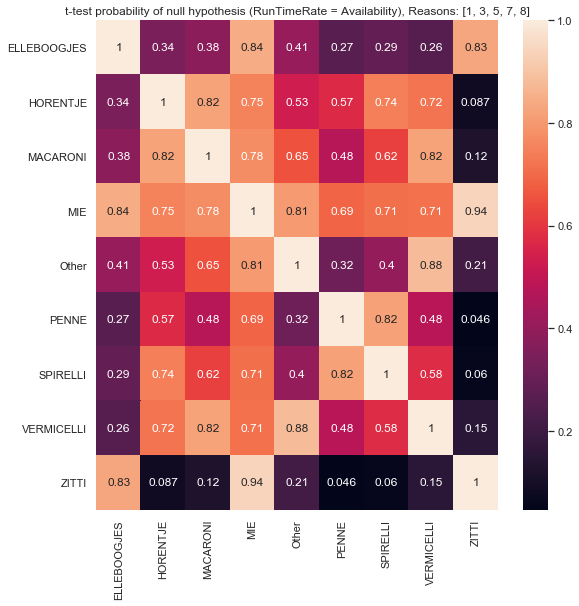

In [12]:
row = list(df_agg.index.get_level_values(0).unique())
from scipy.stats import ttest_ind
from itertools import combinations, permutations
import seaborn as sns; sns.set()
row = list(df_agg.index.get_level_values(0).unique())
pvalues_df = pd.DataFrame(1, row, row)
for i, j in permutations(row, 2):
    tt = ttest_ind(df_agg.loc[i, 'RunTimeRate'], df_agg.loc[j, 'RunTimeRate'])
    pvalues_df.loc[i, j] = tt.pvalue
plt.figure(figsize=(len(row), len(row)))
sns.heatmap(pvalues_df, annot=True)
plt.title('t-test probability of null hypothesis (RunTimeRate = Availability), Reasons: {}'.format(reasons_relative))
plt.yticks(rotation=0)
plt.savefig('D:/temp/ttest.png', dpi=300, bbox_inches ='tight')

In [32]:
from probplot import merge_per_article
df_merged = merge_per_article(df_agg, choice, reasons_relative)

In [33]:
df_merged[['Availability', 'DownTimeStd']]

,Availability,DownTimeStd
PastaType,,
ELLEBOOGJES,0.951694,0.113381
HORENTJE,0.875374,0.226410
MACARONI,0.848652,0.259840
MIE,0.942845,0.094681
Other,0.891337,0.198283
PENNE,0.853796,0.238263
SPIRELLI,0.850911,0.245456
VERMICELLI,0.904758,0.143999
ZITTI,0.939639,0.131694


### Export for simulator file and visualise

In [34]:
def add_breaks(production, maxtime=7200):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        # This loop counts out the breaks and splits it in periods of maxtime and one period of maxtime + diff
        while diff > 0:
            #print(diff)
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE',
                                     'Quantity': maxtime/3600})
                #print(maxtime)
                #print(maxtime/3600)
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                # overwrite the break time
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE',
                     'Quantity': diff/3600})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [35]:
break_pauses

7200

In [36]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName', 'Quantity']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ArticleName != 'NONE']
#df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
df_task = add_breaks(df_task, maxtime=break_pauses)
df_task.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK,30000.0
1,50675,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860,100,MACARONI KORT PLATTE ZAK,30000.0
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK,30000.0
3,50675,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871,100,MACARONI KORT PLATTE ZAK,30000.0
4,50675,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177,10,MACARONI KORT PLATTE ZAK,30000.0


In [37]:
df_prod  = df_task[df_task.ArticleName != 'NONE']
prodtime = df_prod.Duration.sum() / 3600
uptime = df_prod.Duration[df_prod.ReasonId.isin([100])].sum() / 3600
downtime = df_prod.Duration[df_prod.ReasonId.isin(all_reasons)].sum() / 3600

reltime = df_prod.Duration[df_prod.ReasonId.isin(reasons_relative)].sum() / 3600
abstime = df_prod.Duration[df_prod.ReasonId.isin(reasons_absolute)].sum() / 3600
breaktime = df_prod.Duration[df_prod.ReasonId.isin(reasons_break)].sum() / 3600

idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600

print('Production time {:.3f} h'.format(prodtime))
print('> Runtime {:.3f} h'.format(uptime))
print('> Downtime {:.3f} h'.format(downtime))

print('>> Unexpected breakdowns {:.3f} h'.format(reltime))
print('>> Expected breaks {:.3f} h'.format(abstime))
print('>> Pause {:.3f} h'.format(breaktime))

print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

av = uptime/prodtime
print('Availability production time:', av)

Production time 13218.464 h
> Runtime 10309.660 h
> Downtime 2908.804 h
>> Unexpected breakdowns 1413.382 h
>> Expected breaks 1494.684 h
>> Pause 0.000 h
Idle time 3121.736 h
Total time 16340.199 h
Availability production time: 0.7799438953959791


4280


C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


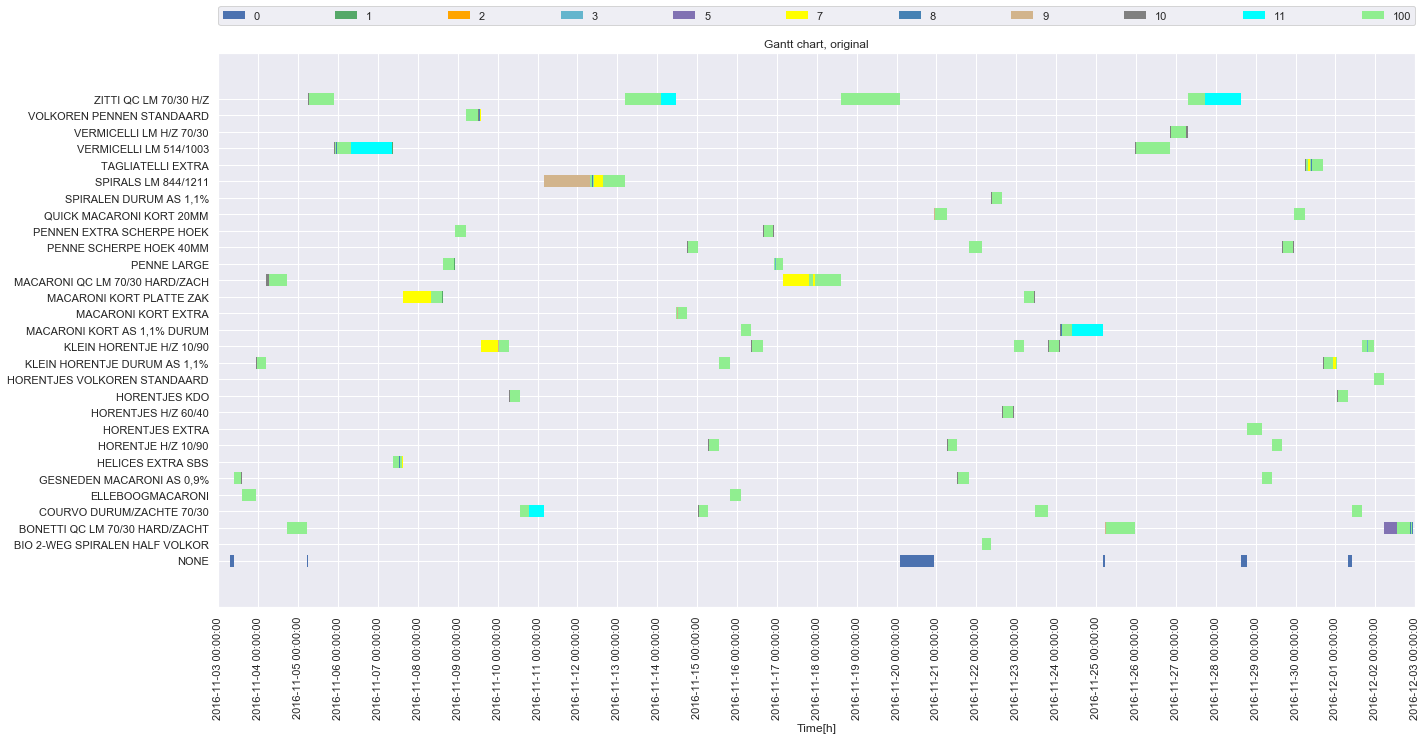

In [38]:
def show_gantt(df_task, start, end):
    plt.figure(figsize=(20, 10))
    # df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    # df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    df_part = df_task[df_task.StartDateUTC.between(start, end) & df_task.EndDateUTC.between(start, end)]
    all_reasons = list(df_task.ReasonId.unique())
    all_reasons.sort()
    plot_gantt(df_part, 'ReasonId', 'ArticleName', order=all_reasons)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # key_list = sorted(by_label)
    # value_list = [by_label[key] for key in key_list]
    # plt.legend(value_list, key_list, loc='lower right')
    plt.title('Gantt chart, original')
    #try:
    #    plt.savefig('D:/temp/gantt.svg', dpi=1200, bbox_inches='tight')
    #except:
    #    pass
    plt.tight_layout()
    plt.show()
show_gantt(df_task, *plotrange)

In [39]:
# def sliding_plot(start, ran):
#     from datetime import datetime, timedelta

#     plotrange = datetime(2016, 11, 2, 0, 0) + timedelta(start), datetime(2016, 11, 2, 0, 0) + timedelta(start+ran)

#     show_gantt(df_task, *plotrange)

In [40]:
# from ipywidgets import interact, interactive, fixed
# import ipywidgets as widgets

# a = widgets.FloatText()
# b = widgets.FloatSlider(min=0, max=100, step=1)
# display(a)
# c = widgets.FloatSlider(min=1, max=14, step=1)

# mylink = widgets.jslink((a, 'value'), (b, 'value'))

# interact(sliding_plot, start=b, ran=7)

In [41]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [42]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'Quantity':'first','StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    #print(len(group))
    # all of the uptime is counted here
    group_uptime = df_task[df_task.ReasonId.isin([100])].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_uptime.columns = ['Uptime']
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_alltime.columns = ['Totaltime']
    group_downtime = df_task[df_task.ReasonId.isin(considered_reasons)].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_downtime.columns = ['Downtime']
    group = pd.concat([group_uptime, group_downtime, group_alltime, group], axis=1)
    group = group.sort_values(by='StartDateUTC')
    group.index = group.index.astype(int)
    group = group.fillna(0)
    return group

def simplify_productions(group, num_minutes):
    df = group.copy()
    #df['Duration'] = df['Duration'] * 60
    #df['Duration'] = df['Duration'].apply(np.round).astype(int)
    #df['Duration'] = round(df['Duration'] / num_minutes) * num_minutes # rounds down to the chosen numbers of seconds
    i = 0
#    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
#         if i == 0:
#             df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round(str(num_minutes) + 's')
#             df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[j, 'Duration'])
#             i += 1
#         df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
#         df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[k, 'Duration'])
#        df.loc[j, ]

    df['StartDateUTC'] = df['StartDateUTC'].dt.round(str(num_minutes) + 's')
    df['EndDateUTC'] = df['EndDateUTC'].dt.round(str(num_minutes) + 's')
    df['Duration'] = (df['EndDateUTC'] - df['StartDateUTC']).dt.total_seconds()
    df = df[df['Duration'] > 0]
    #df['Duration'] = df['Duration']/60
    return df

def remove_breaks(group, min_length=3600):
    df = group.copy()
    j = 0
    while j < len(df):
        temp = df.iloc[j]
        if (temp['ArticleName'] == 'NONE') & (temp['Totaltime'] < min_length):
            # don't turn off the machine (no energy saving)
            curidx = temp.name
            previdx = df.iloc[j-1].name
            if (j > 0): #& (df.loc[previdx, 'ArticleName'] != 'NONE'):
                # extend the previous job
                df.loc[previdx, 'EndDateUTC'] = df.loc[curidx, 'EndDateUTC']
                df.loc[previdx, 'Totaltime'] += df.loc[curidx, 'Totaltime']
                df.loc[previdx, 'Uptime'] += df.loc[curidx, 'Uptime']
                df.loc[previdx, 'Downtime'] += df.loc[curidx, 'Downtime']
                df = df.drop(curidx)
                j -= 1
            else:
                pass
                #print('Something unexpected happened!')
                #print(curidx, df.loc[previdx, 'ArticleName'])
        j += 1
    return df
                    

def save_durations(group, output, beforedays=None, randomfactor=None, ignore_break=False):
    out = group[['Uptime', 'Totaltime', 'Quantity', 'StartDateUTC', 'EndDateUTC', 'ArticleName']].copy()
    out.columns = ['Uptime', 'Totaltime', 'Quantity', 'Start', 'End', 'Product']
    out[['Uptime', 'Totaltime']] = out[['Uptime', 'Totaltime']] / 3600
    out = add_column_type(out , 'Product', 'PastaType')
    out.columns.values[-1] = 'Type'
    to_convert_dates = ['Start', 'End']
    if beforedays:
        addedtime = np.full(np.array(out['End']).shape, beforedays)
        if randomfactor:
            addedtime += np.random.randint(randomfactor + 1, size=addedtime.shape)
        out['Before'] = pd.to_datetime(out['End']) + pd.to_timedelta(addedtime, unit="D")
        if ignore_break:
            out.loc[out['Product'] == 'NONE', 'Before']= out.loc[:,'End'].iloc[-1]
        to_convert_dates.append('Before')
    for col in to_convert_dates:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.index.name = 'ID'
    out.to_csv(output)
    
def construct_downtimes(group, reasons):
    dt = group.copy()
    dt = dt[dt['ReasonId'].isin(reasons)]
    return dt

def save_downtimes(dt, output):
    out = dt.copy()
    out = out[['StartDateUTC', 'EndDateUTC']]
    out = out.reset_index(drop=True)
    out.index.name = 'ID'
    out.to_csv(output)

#print(len(df_task))
group = group_productions(df_task)
#print(len(group))
print(group.columns)
group = remove_breaks(group, turn_off_if)
len(group)
#group = simplify_productions(group, 600)
#print(len(group))
downtime = construct_downtimes(df_task, considered_reasons)
save_downtimes(downtime, os.path.join(filepath, 'historicalDownPeriods.csv'))

Index(['Uptime', 'Downtime', 'Totaltime', 'Quantity', 'StartDateUTC',
       'EndDateUTC', 'ArticleName'],
      dtype='object')


In [43]:
group = add_column_type(group, choice=choice)

In [44]:
group.head()

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType
ProductionRequestId,,,,,,,,
50675,18996.0,655.0,19651.0,30000.0,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK,MACARONI
-1,0.0,0.0,7200.0,2.0,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE,NONE
-2,0.0,0.0,7200.0,2.0,2016-01-19 21:49:18.047,2016-01-19 23:49:18.047,NONE,NONE
-3,0.0,0.0,7200.0,2.0,2016-01-19 23:49:18.047,2016-01-20 01:49:18.047,NONE,NONE
-4,0.0,0.0,7200.0,2.0,2016-01-20 01:49:18.047,2016-01-20 03:49:18.047,NONE,NONE


In [45]:
prodtime = group.Totaltime[group.ArticleName != 'NONE'].sum() / 3600
print('Production time {:.3f} h'.format(prodtime))
idletime = group.Totaltime[group.ArticleName == 'NONE'].sum() / 3600
print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13299.259 h
Idle time 3040.940 h
Total time 16340.199 h


In [46]:
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'), beforedays=7, randomfactor=7, ignore_break=True)
# reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
# group['ReasonId'] = reasonlist

In [47]:
def energy_per_production(group, file_speed, choice=None, df_merged=None):
    articlenum = len(group.ArticleName.unique())
    fs = pd.read_csv(file_speed, index_col=0)
    fs = fs[fs.ProductDescription.isin(list(group.ArticleName))].reset_index(drop=True)
    #print(fs.ProductDescription)
    rand1 = pd.Series(np.random.random_sample((len(fs),)) * 0.2 + 0.1)
    rand2 = pd.Series(np.random.random_sample((len(fs),)) * 0.05 + 0.05)
    energycons = pd.concat([pd.Series(fs.ProductDescription), 
                            rand1,
                            rand2, 
                            pd.Series(fs.TargetProductionRate)], axis=1)
    if choice:
        assert(df_merged is not None)
        energycons = add_column_type(energycons, from_col='ProductDescription', choice=choice)
        energycons = energycons.merge(df_merged[['Availability']], left_on=choice, right_index=True)
        energycons = energycons.drop(choice, axis=1)
        energycons.columns = ['Product', 'UnitPrice',  'Power', 'TargetProductionRate', 'Availability']
    else:
        energycons.columns = ['Product', 'UnitPrice',  'Power', 'TargetProductionRate']
    #energycons.insert(1, 'UnitPrice', 5)
    #energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    #energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    if choice:
        energycons = energycons.append({'Product': 'NONE', 'UnitPrice': 0, 'Power': 0, 'TargetProductionRate': 1,
                                       'Availability': 1}, ignore_index=True)   
    else:
        energycons = energycons.append({'Product': 'NONE', 'UnitPrice': 0, 
                                        'Power': 0, 'TargetProductionRate': 1}, ignore_index=True)
    return energycons

energycons = energy_per_production(group, os.path.join(filepath, file_speed), choice=choice, df_merged=df_merged)
# energycons = add_column_type(energycons, 'Product', 'PastaType')
# energycons.columns.values[-1] = 'Type'
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [48]:
group.head(2)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType
ProductionRequestId,,,,,,,,
50675,18996.0,655.0,19651.0,30000.0,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK,MACARONI
-1,0.0,0.0,7200.0,2.0,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE,NONE


In [49]:
energycons.tail(2)

,Product,UnitPrice,Power,TargetProductionRate,Availability
41,ZITTI QC LM 70/30 H/Z,0.12142,0.088419,3000,0.939639
42,NONE,0.00000,0.000000,1,1.000000


In [72]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)
    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [51]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

In [52]:
downtime.head(2)

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK,30000.0
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK,30000.0


In [53]:
plotrange[0]

datetime.datetime(2016, 11, 3, 6, 0)

C:\Users\jdavid\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

-1491


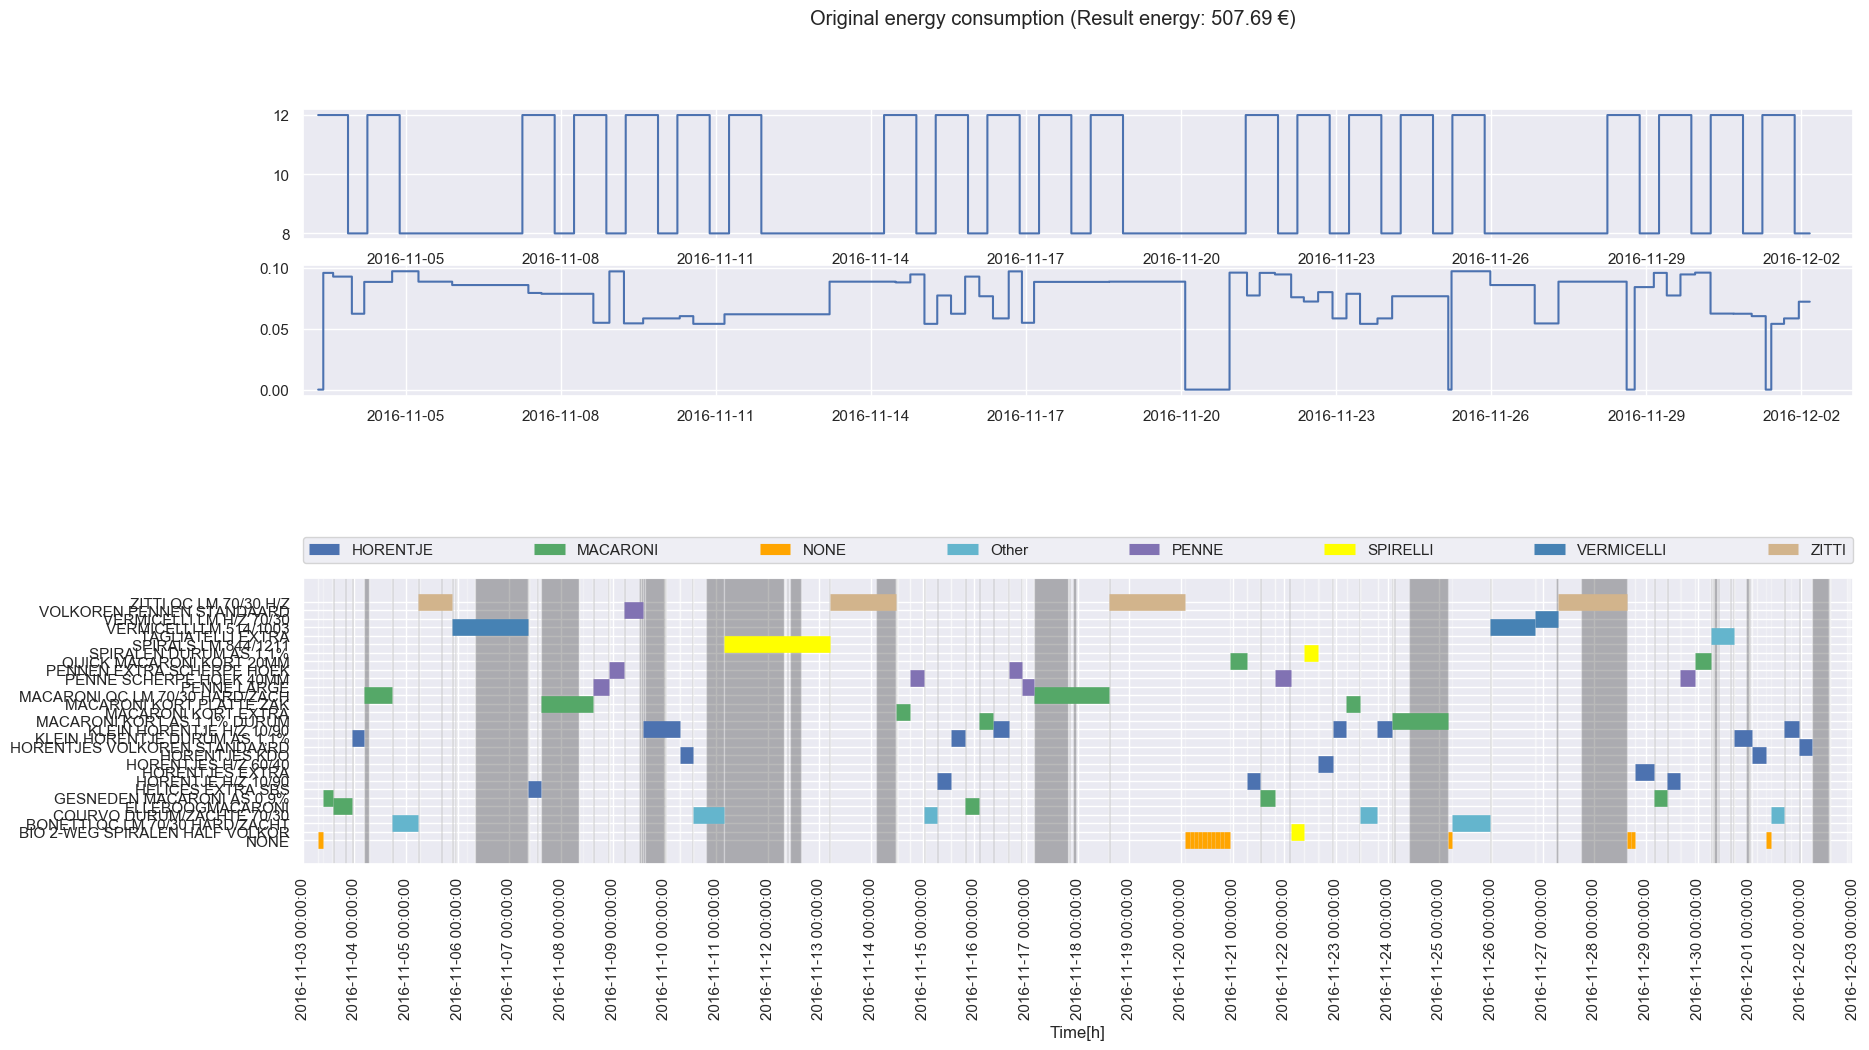

In [54]:
group_part = group[(group.StartDateUTC >= plotrange[0]) & (group.EndDateUTC <= plotrange[1])]
downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

plt.figure(figsize=(20, 10), dpi=100)
c, table = calculate_energy_cost(group_part, prices, energycons, True)

plt.subplot(5,1,(4,5))
timerange = plot_gantt(add_column_type(group_part, choice=choice), choice, 'ArticleName', downtimes=downtime_temp)
plt.subplot(5,1,1)
plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(5,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
try:
    plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
except:
    print('No output made.')
    pass
plt.show()

In [55]:
group_part.head(5)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType,Start,End
ProductionRequestId,,,,,,,,,,
-1491,0.0,0.0,8562.240,2.0,2016-11-03 07:08:12.890,2016-11-03 09:30:55.130,NONE,NONE,7.136914,9.515314
61962,15621.0,859.0,16480.000,40000.0,2016-11-03 09:30:55.130,2016-11-03 14:05:35.653,"GESNEDEN MACARONI AS 0,9%",MACARONI,9.515314,14.093237
62082,29325.0,1974.0,31303.990,45000.0,2016-11-03 14:05:35.653,2016-11-03 22:47:19.140,ELLEBOOGMACARONI,MACARONI,14.093237,22.788650
62179,19469.0,1236.0,20705.000,30000.0,2016-11-03 22:47:19.140,2016-11-04 04:32:24.930,"KLEIN HORENTJE DURUM AS 1,1%",HORENTJE,22.788650,28.540258
62022,38388.0,8257.0,46650.004,35000.0,2016-11-04 04:32:24.930,2016-11-04 17:29:54.697,MACARONI QC LM 70/30 HARD/ZACH,MACARONI,28.540258,41.498527


In [56]:
# start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
# end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
# start_time, end_time

In [57]:
break

SyntaxError: 'break' outside loop (<ipython-input-57-6aaf1f276005>, line 1)

In [59]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['historicalDownPeriods.csv',
                                             '',
                                             'generated_productRelatedCharacteristics.csv', 
                                             'generated_hourly_energy_price.csv', 
                                             'generated_jobInfoProd.csv']]
best_result, orig_result, best_sched, orig_sched, best_curve, mean_curve, worst_curve, gen = run_opt(*plotrange, 
        *files, 
        1, 1000, 0.4, 0.4, 12, num_mutations=1, adaptive=[],
        stop_condition='num_iterations', stop_value=1000, 
        weight_energy = 1, weight_failure=0, weight_conversion = 1, weight_before = 10000)

Using historical method
999/1000:	539.1168039014003
Elapsed time: 57.58 s

Candidate schedule [62898 62523 63062 -1536 62215 62217 62402 61962 63169 62023 61892 -1513
 62082 62216 62253 62179 -1522 -1518 62260 62024 62848 62497 62528 63181
 62945 62805 -1514 62630 62496 62022 62231 62218 62623 63133 62259 62899
 62384 62850 -1535 62214 62753 62465 62258 63070 62763 63056 -1520 62983
 62985 62788 -1517 63089 62529 62495 -1515 -1491 62769 63110 62729 62628
 62622 62904 -1540 -1516 -1521 -1531 -1519 62854 62789 62984 63151]
Candidate failure cost: 0
Candidate energy cost: 484.11680390140026
Candidate conversion cost: 55
Candidate deadline cost 0
Candidate total cost: 539.1168039014003

Original schedule: [-1491, 61962, 62082, 62179, 62022, 62024, 61892, 62023, 62253, 62217, 62216, 62215, 62218, 62214, 62259, 62260, 62231, 62384, 62402, 62465, 62497, 62495, 62496, 62523, 62258, 62528, 62529, 62623, 62630, 62753, -1513, -1514, -1515, -1516, -1517, -1518, -1519, -1520, -1521, -1522, 62769, 6

In [60]:
best_sched = list(best_sched.keys())

In [61]:
def reorder_schedule(id_list, schedule):
    df = schedule.loc[id_list]
    startdate = df['StartDateUTC'].min()
    #print(df)
    for row in df.T:
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Totaltime'], unit='s')
        df.loc[row, 'EndDateUTC'] = enddate
        startdate = enddate
    return df

In [62]:
group_opt = reorder_schedule(best_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType,ReasonId
ProductionRequestId,,,,,,,,,
62898,29039.0,123.0,29162.000,70000.000000,2016-11-03 07:08:12.890,2016-11-03 15:14:14.890,COURVO DURUM/ZACHTE 70/30,Other,100
62523,22641.0,1047.0,23688.000,35000.000000,2016-11-03 15:14:14.890,2016-11-03 21:49:02.890,ELLEBOOGMACARONI,MACARONI,100
63062,31243.0,788.0,32033.940,50000.000000,2016-11-03 21:49:02.890,2016-11-04 06:42:56.830,HORENTJES EXTRA,HORENTJE,100
-1536,0.0,0.0,6236.610,1.732392,2016-11-04 06:42:56.830,2016-11-04 08:26:53.440,NONE,NONE,0
62215,23939.0,383.0,24332.993,35000.000000,2016-11-04 08:26:53.440,2016-11-04 15:12:26.433,PENNEN EXTRA SCHERPE HOEK,PENNE,100


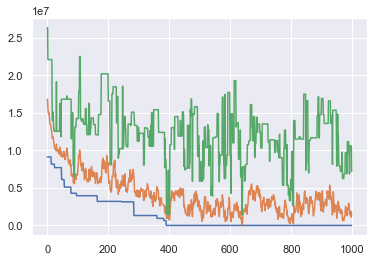

In [63]:
plt.plot(best_curve)
plt.plot(mean_curve)
plt.plot(worst_curve)

In [64]:
group_opt.head(10)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,PastaType,ReasonId
ProductionRequestId,,,,,,,,,
62898,29039.0,123.0,29162.000,70000.000000,2016-11-03 07:08:12.890,2016-11-03 15:14:14.890,COURVO DURUM/ZACHTE 70/30,Other,100
62523,22641.0,1047.0,23688.000,35000.000000,2016-11-03 15:14:14.890,2016-11-03 21:49:02.890,ELLEBOOGMACARONI,MACARONI,100
63062,31243.0,788.0,32033.940,50000.000000,2016-11-03 21:49:02.890,2016-11-04 06:42:56.830,HORENTJES EXTRA,HORENTJE,100
-1536,0.0,0.0,6236.610,1.732392,2016-11-04 06:42:56.830,2016-11-04 08:26:53.440,NONE,NONE,0
62215,23939.0,383.0,24332.993,35000.000000,2016-11-04 08:26:53.440,2016-11-04 15:12:26.433,PENNEN EXTRA SCHERPE HOEK,PENNE,100
62217,22293.0,64572.0,86870.010,35000.000000,2016-11-04 15:12:26.433,2016-11-05 15:20:16.443,MACARONI KORT PLATTE ZAK,MACARONI,100
62402,21502.0,2906.0,24413.007,35000.000000,2016-11-05 15:20:16.443,2016-11-05 22:07:09.450,MACARONI KORT EXTRA,MACARONI,100
61962,15621.0,859.0,16480.000,40000.000000,2016-11-05 22:07:09.450,2016-11-06 02:41:49.450,"GESNEDEN MACARONI AS 0,9%",MACARONI,100
63169,22825.0,7326.0,30151.000,35000.000000,2016-11-06 02:41:49.450,2016-11-06 11:04:20.450,"KLEIN HORENTJE DURUM AS 1,1%",HORENTJE,100


62898


C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


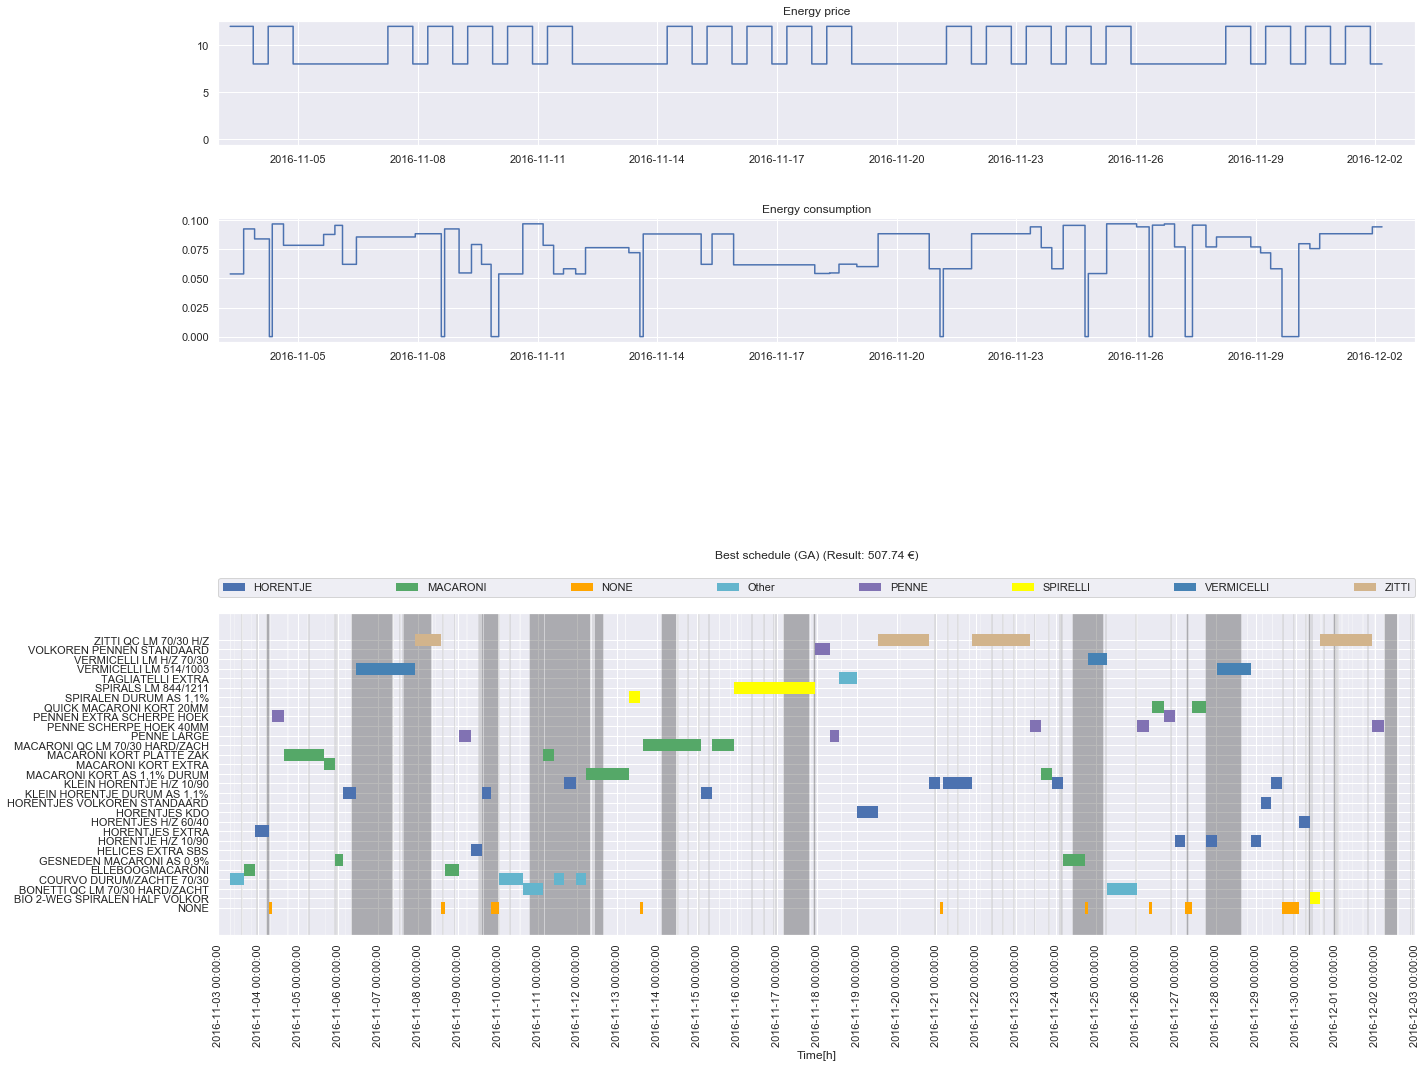

In [65]:
plt.figure(figsize=(20, 15))
show_energy_plot(add_column_type(group_opt, choice=choice), prices, energycons, 'Best schedule (GA)', choice, 
                 downtimes=downtime_temp)
plt.show()

In [66]:
# group_part = group_opt[group_opt.StartDateUTC.between(*plotrange)]
# downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

# plt.figure(figsize=(20, 10))
# c, table = calculate_energy_cost(group_part, prices, energycons, True)

# plt.subplot(5,1,(4,5))
# timerange = plot_gantt(add_column_type(group_part, choice='PastaType'), 'PastaType', 'ArticleName', downtimes=downtime_temp)
# plt.subplot(5,1,1)
# plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Euro, drawstyle='steps-post')

# plt.subplot(5,1,2)
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Power, drawstyle='steps-post')
# try:
#     plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
# except:
#     print('No output made.')
#     pass
# plt.show()

In [67]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [68]:
# df_task.Resource.unique()

In [69]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [70]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours